# **Motion Detection**

How to use Deep Optical Flow to estimate motion from a moving camera, the algorithm consists of 4 main steps:


1. Compute Dense Optical Flow
2. Obtain background mask from Optical Flow
3. Extract Foreground motion mask
4. Detect Movers on Motion Mask

Optical Flow is normally unable to detect moving objects when the camera is moving. The camera motion induces high levels of background noise in the flow estimates that are difficult to get rid of. To denoise the flow, we will use a special RANSAC algorithm to determine the background (inliers) and then extract the foreground (outliers). From the foreground, we can detect the moving objects.

![1 tVkKwrBZJz90fdredysOnw.png](<attachment:1 tVkKwrBZJz90fdredysOnw.png>)
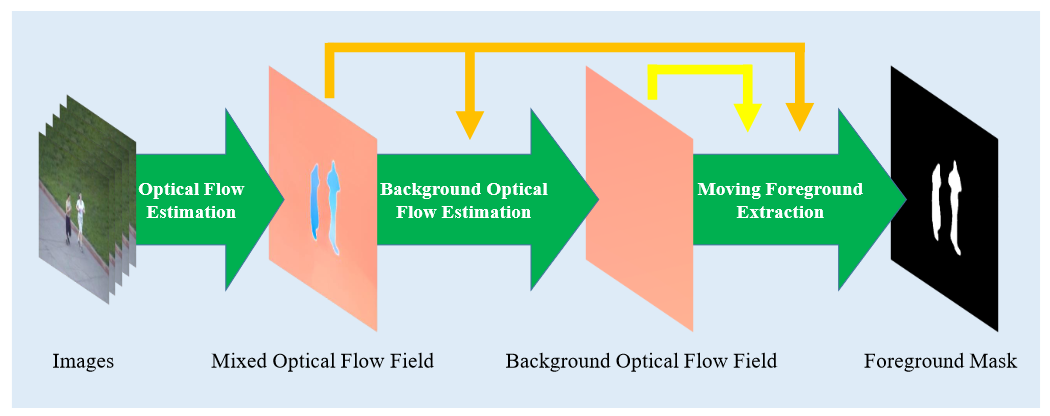

## **RANSAC Algorithm**

This approach heavily relies on a special RANSAC Algorithm to obtain a model for the Background Optical Flow

![1 iQGyZGm1uDPjgdBigIKSpw.png](<attachment:1 iQGyZGm1uDPjgdBigIKSpw.png>)
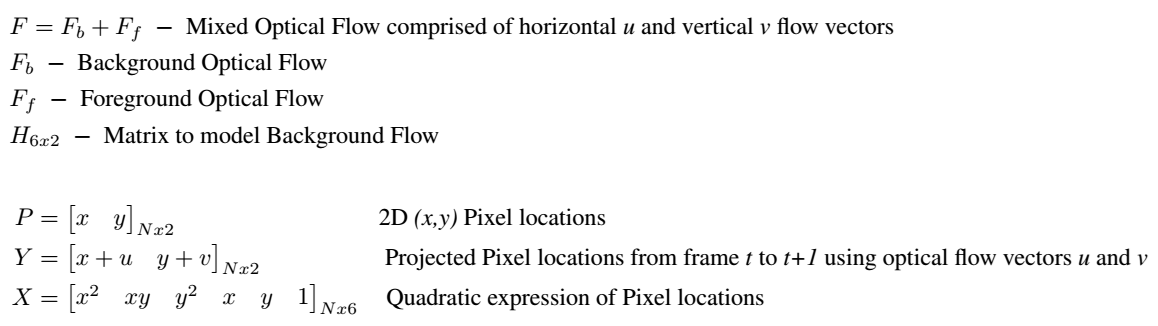

$min ||Y - XH||^2$ $\rightarrow$ $H = (X^T X)^{-1}X^TY$

![1 MRCO7autKDJoxBdorsQ3-w.png](<attachment:1 MRCO7autKDJoxBdorsQ3-w.png>)
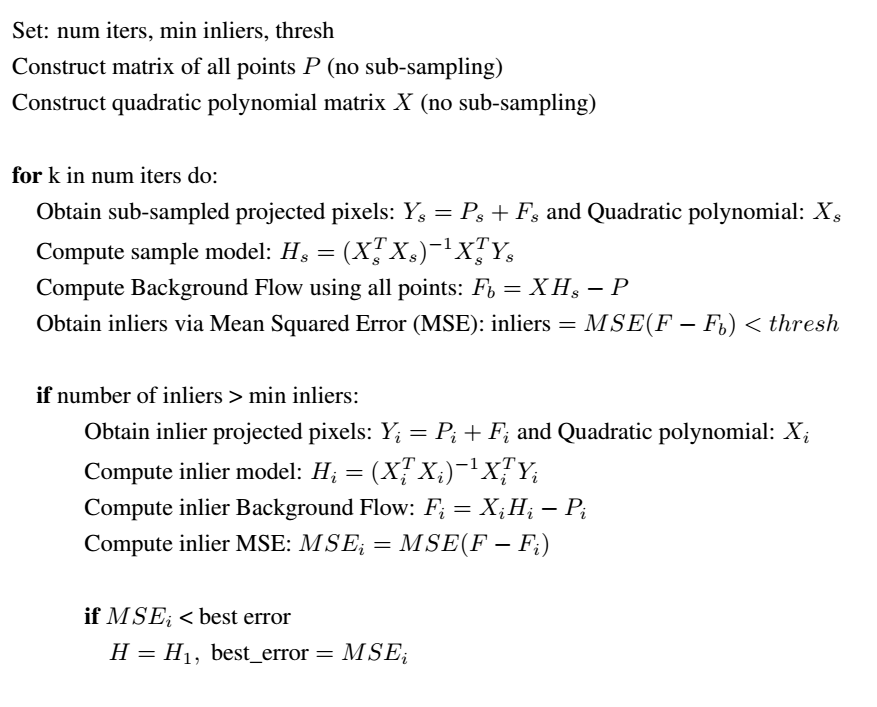

In [84]:
import os
import sys
from glob import glob
import re
import numpy as np
import cv2

import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
%matplotlib inline


from motion_detection_utils import *
from constrained_ransac import *

#### Get RAFT Model

In [130]:
# add RAFT to core path
sys.path.append(r'C:\Users\itber\Documents\learning\self_tutorials\CV_projects\mars_challenge\RAFT\core')
sys.path.append(r'C:\Users\itber\Documents\learning\self_tutorials\CV_projects\mars_challenge')
     
from raft_utils import *

In [131]:
model = load_model(r"C:\Users\itber\Documents\learning\self_tutorials\CV_projects\mars_challenge\RAFT\models\raft-sintel.pth", args=Args())

Get video sequence from dataset

In [133]:
# fpath = r"C:\Users\itber\Documents\datasets\VisDrone\VisDrone2019-VID-train\sequences\uav0000352_05980_v"
fpath = r"C:\Users\itber\Documents\datasets\VisDrone\VisDrone2019-VID-train\sequences\uav0000360_00001_v"

image_paths = sorted(glob(f"{fpath}/*.jpg"), key=lambda x:float(re.findall("(\d+)",x)[0]))
len(image_paths)

421

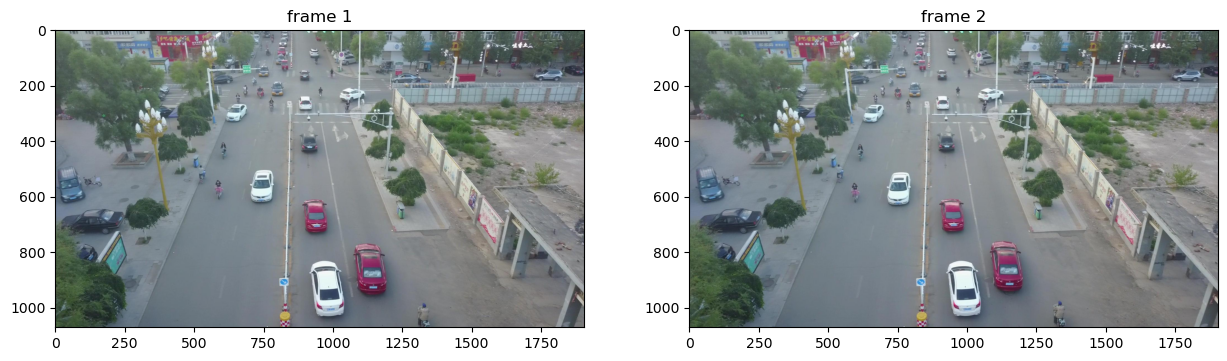

In [134]:
idx = 10 # 180 # 50 # 25 # 100
frame1 = cv2.cvtColor(cv2.imread(image_paths[idx]), cv2.COLOR_BGR2RGB)
frame2 = cv2.cvtColor(cv2.imread(image_paths[idx + 1]), cv2.COLOR_BGR2RGB)

_, ax = plt.subplots(1, 2, figsize=(15, 10))
ax[0].imshow(frame1)
ax[0].set_title("frame 1")
ax[1].imshow(frame2)
ax[1].set_title("frame 2");

## Compute Optical Flow

In [135]:
# resize frames
H, W, _ = frame1.shape
H2, W2 = H//2, W//2


frame1 = cv2.resize(frame1, (W2, H2))
frame2 = cv2.resize(frame2, (W2, H2))

In [137]:
flow = inference(model, 
                 frame1,
                 frame2, 
                 iters=12, 
                 test_mode=False, 
                 device='cuda')[-1]

In [138]:
flow_np = flow.squeeze().cpu().numpy().transpose(1, 2, 0)
mag, ang = cv2.cartToPolar(flow_np[:, :, 0], flow_np[:, :, 1])

#### Visualize Computed Flow

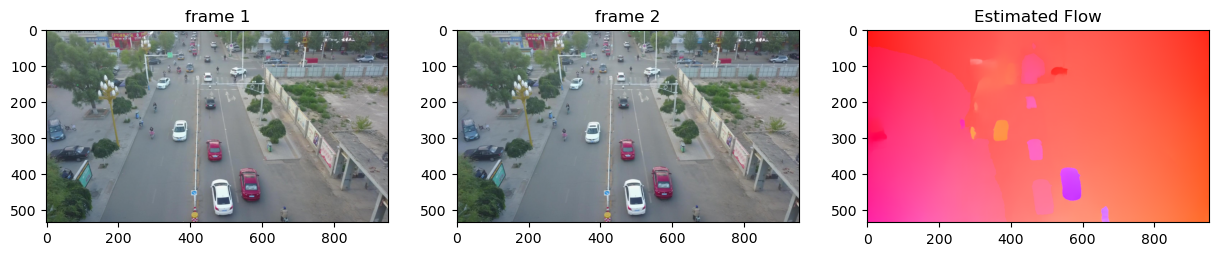

In [139]:
_, ax = plt.subplots(1, 3, figsize=(15, 10))
ax[0].imshow(frame1)
ax[0].set_title("frame 1")
ax[1].imshow(frame2)
ax[1].set_title("frame 2")
ax[2].imshow(flow_viz.flow_to_image(flow_np))
ax[2].set_title("Estimated Flow");

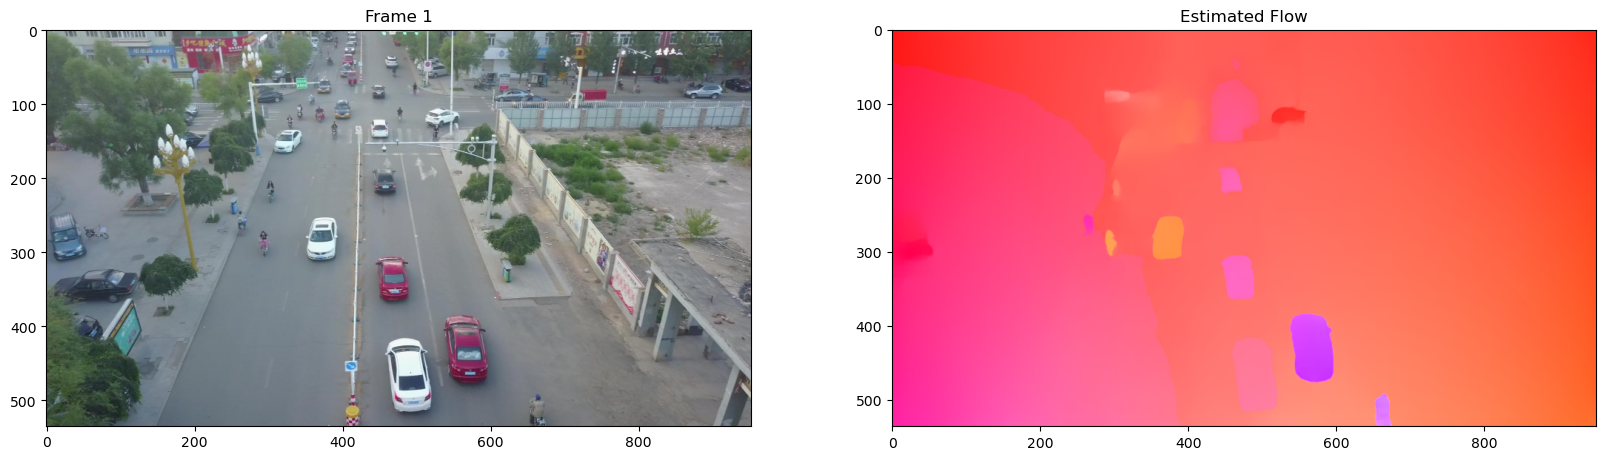

In [93]:
_, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].imshow(frame1)
ax[0].set_title("Frame 1")
ax[1].imshow(flow_viz.flow_to_image(flow_np))
ax[1].set_title("Estimated Flow");

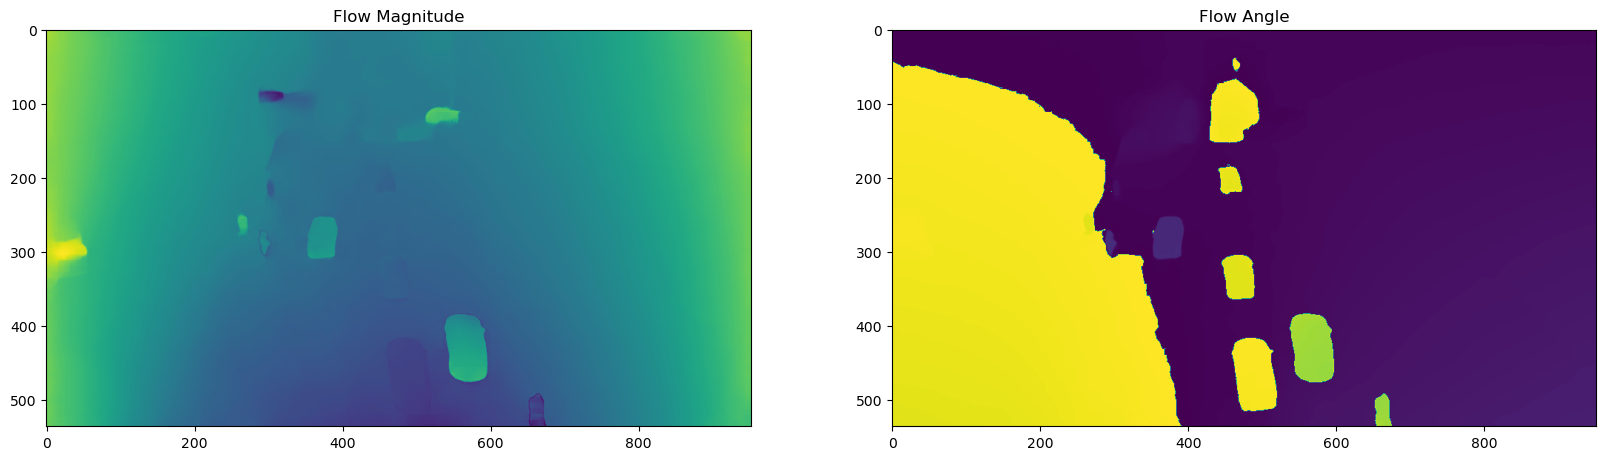

In [140]:
_, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].imshow(mag, cmap='viridis')
ax[0].set_title("Flow Magnitude")
ax[1].imshow(ang, cmap='viridis')
ax[1].set_title("Flow Angle");

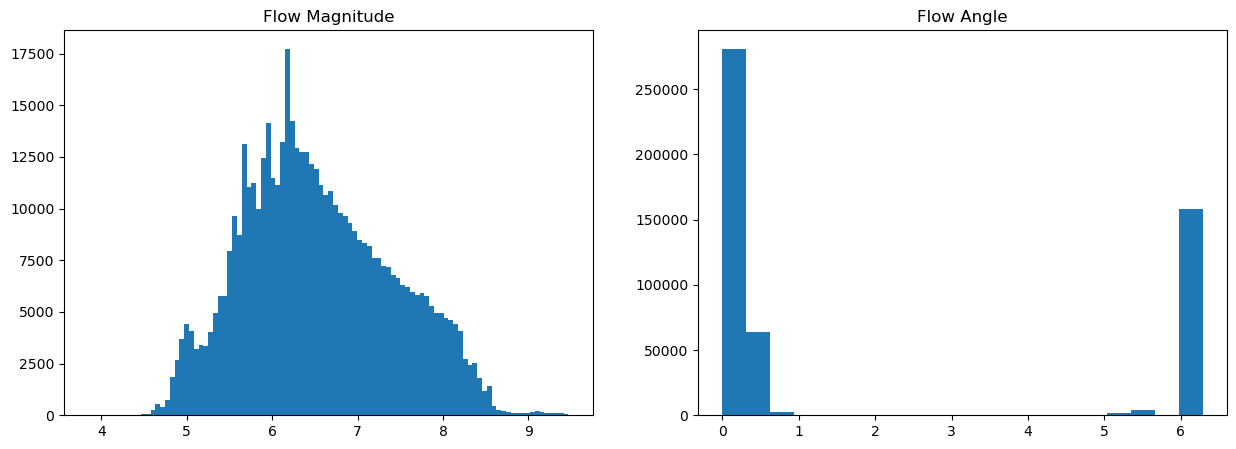

In [95]:
_, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].hist(mag.reshape((-1)), bins=100);
ax[0].set_title("Flow Magnitude")
ax[1].hist(ang.reshape((-1)), bins=20);
ax[1].set_title("Flow Angle");

### Let's try to threshold the predicted flow to get the movers

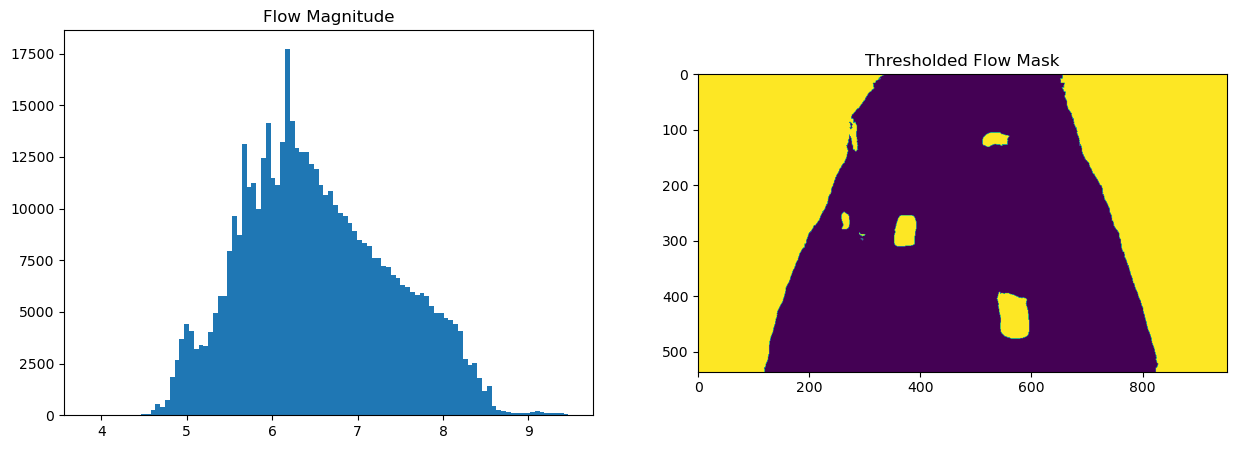

In [123]:
_, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].hist(mag.reshape((-1)), bins=100);
ax[0].set_title("Flow Magnitude")
ax[1].imshow(mag > mag.mean())
ax[1].set_title("Thresholded Flow Mask");

Try removing the camera motion from the flow estimates

In [125]:
flow_np.shape

(536, 952, 2)

In [124]:
# get apparent flow from camera motion
u_speed, v_speed = flow_np.mean(axis=0).mean(axis=0)

u_speed, v_speed

(6.379456, 0.5509204)

In [126]:
corrected_mag, _ = cv2.cartToPolar(flow_np[:, :, 0] - u_speed, flow_np[:, :, 1] - v_speed)

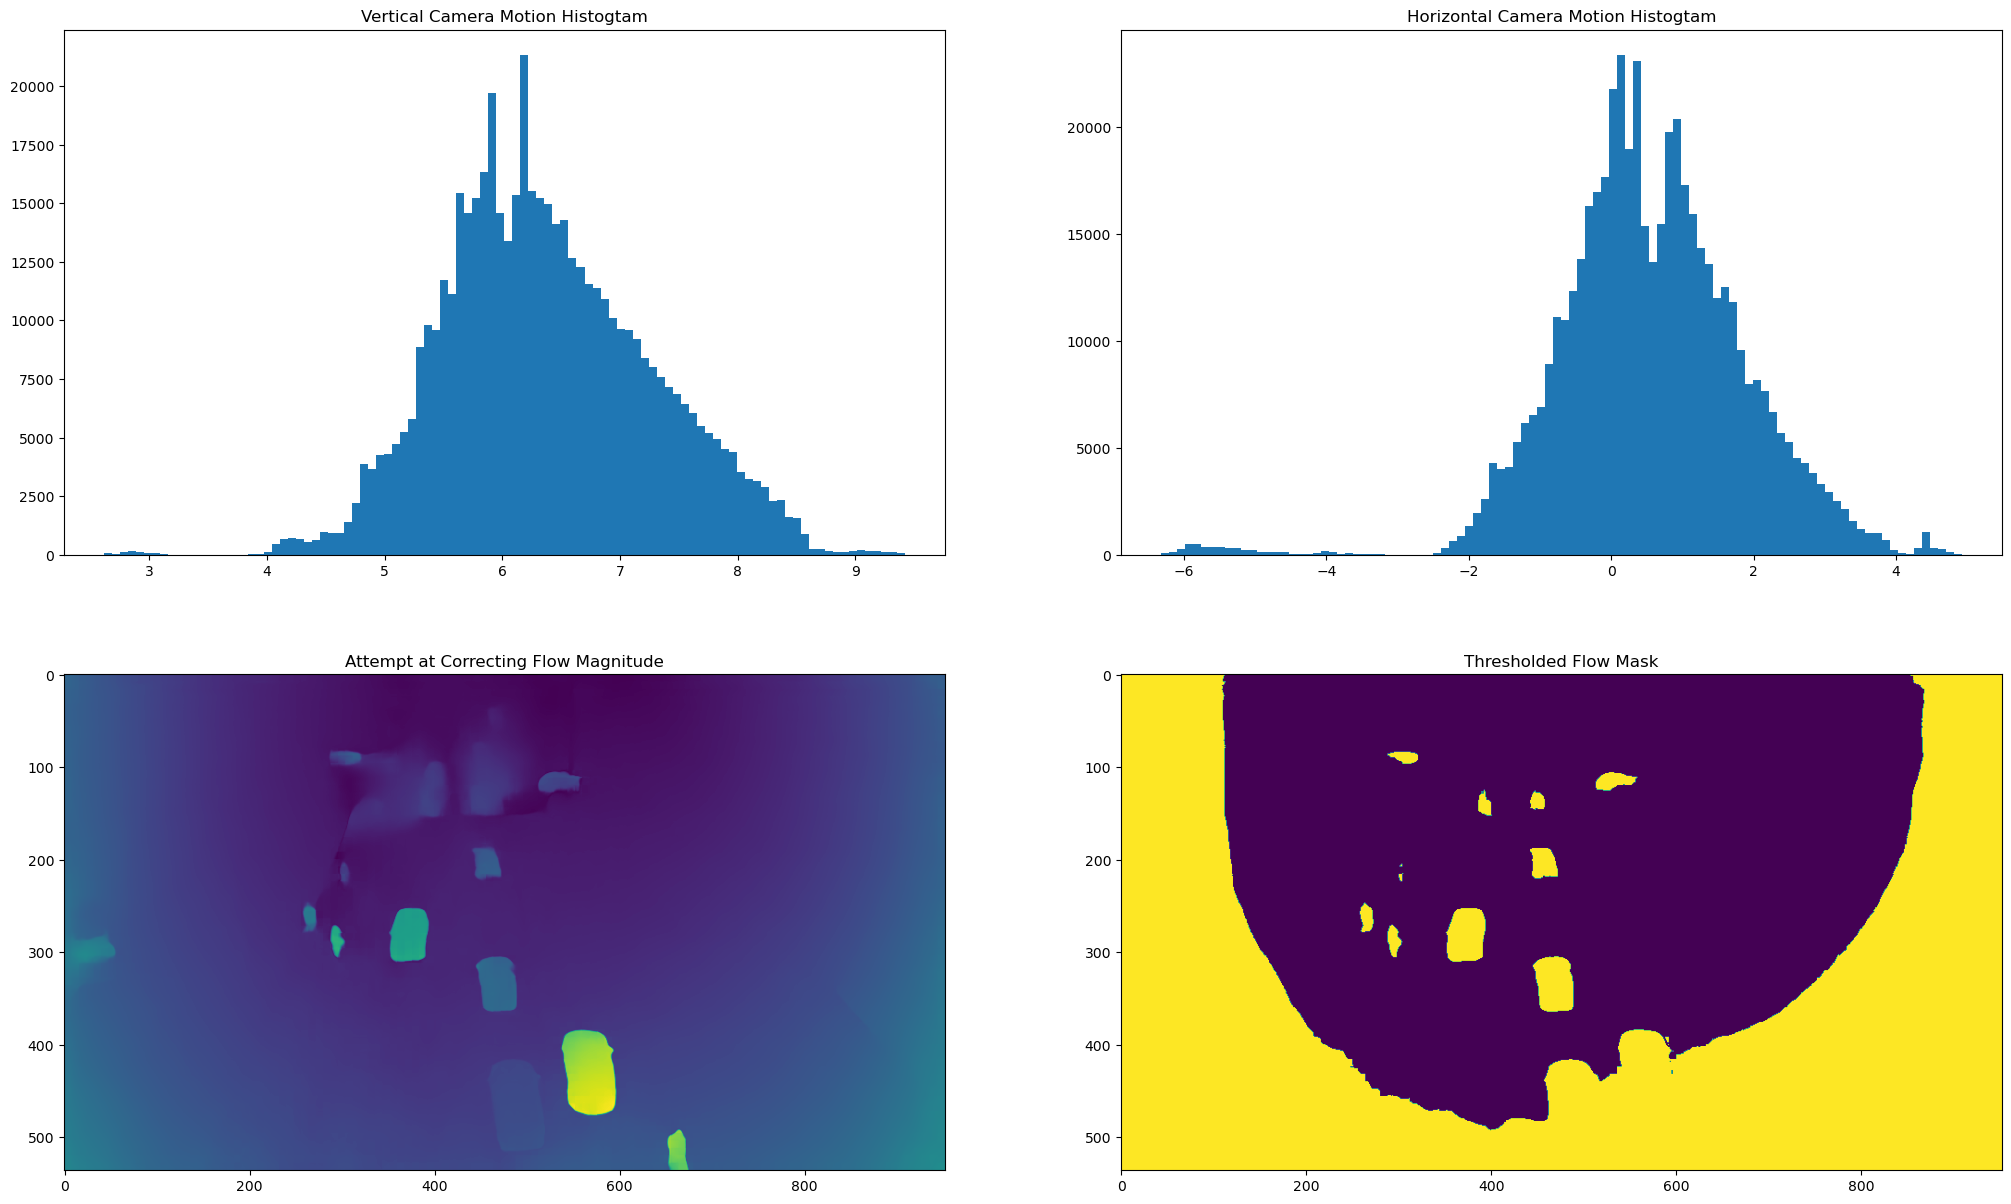

In [127]:
_, ax = plt.subplots(2, 2, figsize=(25, 15))
ax[0, 0].hist(flow_np[:, :, 0].flatten(), bins=100);
ax[0, 0].set_title("Vertical Camera Motion Histogtam")
ax[0, 1].hist(flow_np[:, :, 1].flatten(), bins=100);
ax[0, 1].set_title("Horizontal Camera Motion Histogtam")
ax[1, 0].imshow(corrected_mag)
ax[1, 0].set_title("Attempt at Correcting Flow Magnitude");
ax[1, 1].imshow(corrected_mag > corrected_mag.mean())
ax[1, 1].set_title("Thresholded Flow Mask");

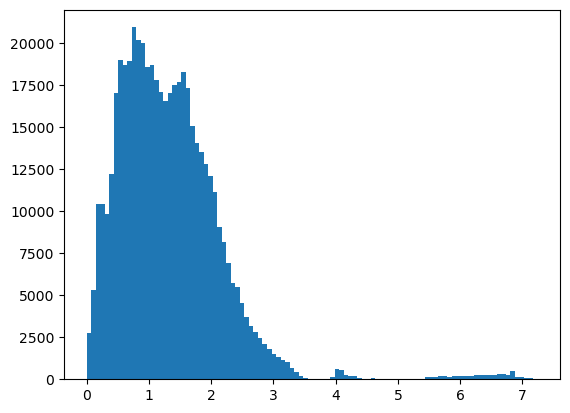

In [128]:
plt.hist(corrected_mag.flatten(), bins=100);

It doesn't work! We need a way to find the movers (signal) in the background (noise). Previously, we have used Sparse Optical Flow to perform Camera Motion Compensation, but this will add too much computational overhead to use in addition to deep dense Optical Flow. 

## **Use RANSAC to get Predicted H matrix**

In [180]:
h, w, _ = flow_np.shape
P, X = get_px(w, h)
# index, n_ttl, n_s = get_sampling_index(w, h, s=50, p=0.5)
index, n_ttl, n_s = get_sampling_index(w, h, s=30, p=0.5)
H, error = cra(flow_np, P, X, index, n_ttl, n_s, thresh=0.01,  min_inliers=10000, num_iters=50)

H, error

(array([[ 1.04611526e-05,  1.43431164e-06],
        [-3.12967060e-06, -1.08265733e-06],
        [-1.71899465e-06,  1.00437266e-05],
        [ 9.89973991e-01, -3.80212813e-04],
        [-5.49719173e-04,  9.95757587e-01],
        [ 8.64109716e+00,  2.57797423e-01]]),
 317.06339194709426)

### Visualize Sampling

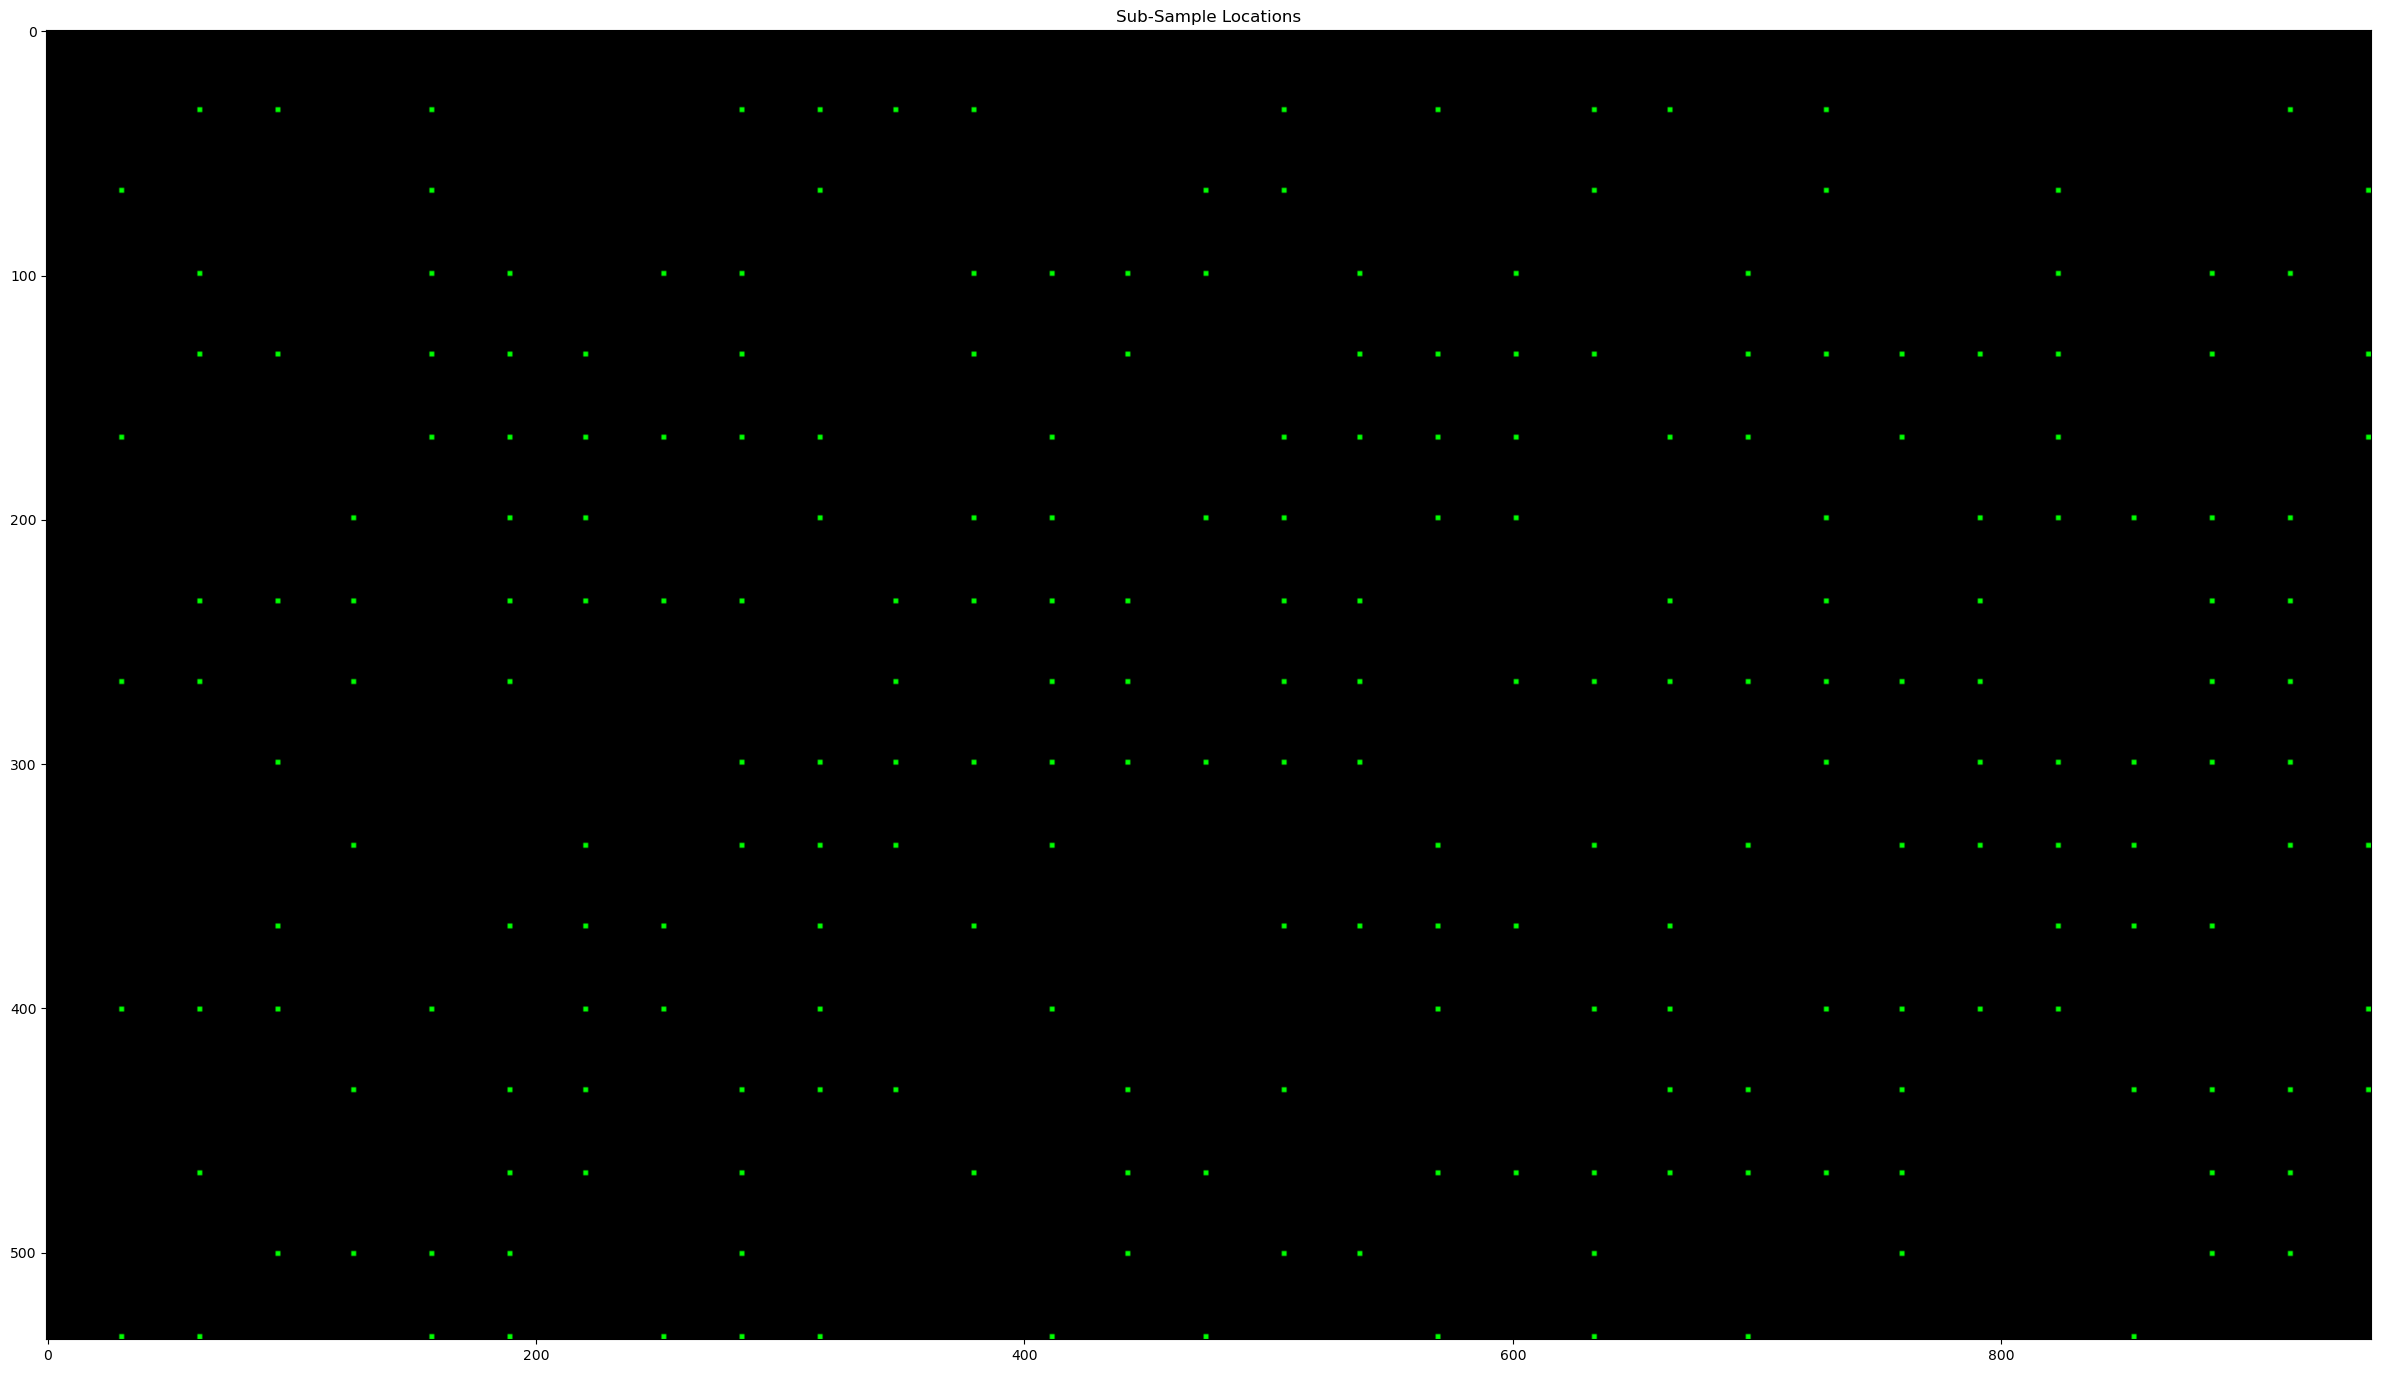

In [181]:
sample_index = index[np.sort(np.random.choice(np.arange(0, n_ttl), size=n_s , replace=False))]
canvas = np.zeros((h, w, 3), dtype=np.uint8)

for _a, _b in sample_index:
    # canvas[_b, _a, [0, 2]] = 255
    canvas[_b-1:_b+1, _a-1:_a+1, 1] = 255

plt.figure(figsize=(30,30))
plt.imshow(canvas)
plt.title("Sub-Sample Locations");

### Use best model (H matrix) to get predicted Background flow

Need to remove the pixel locations from the flow estimate

In [182]:
# Fb = (X @ H)[:, :2] - P
Fb = (X @ H) - P

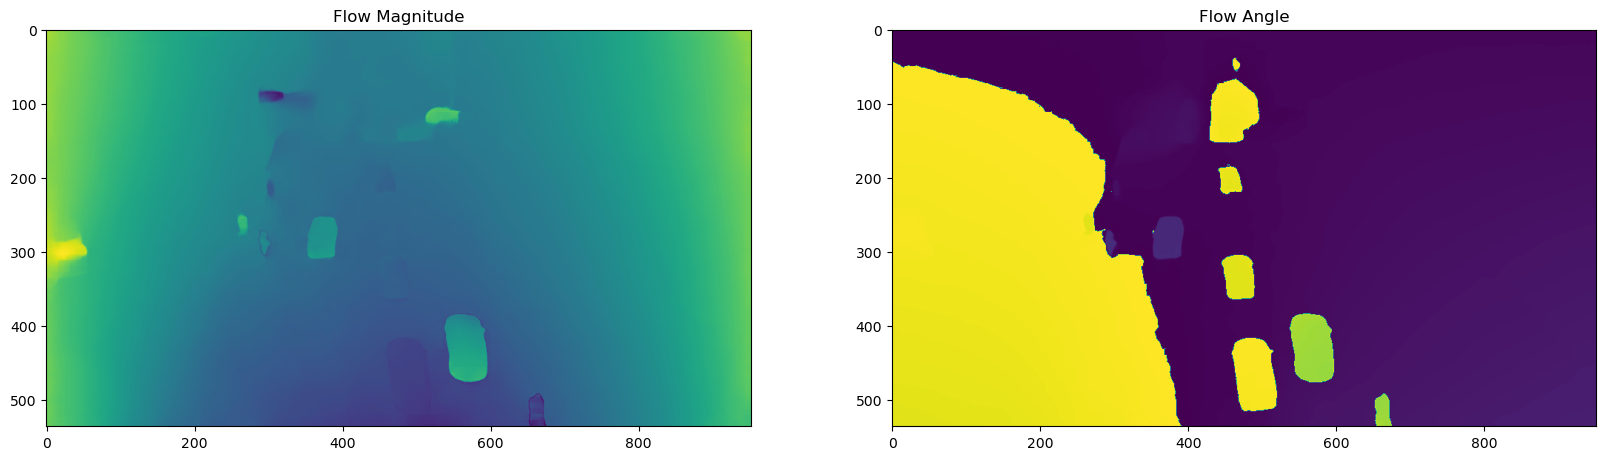

In [183]:
_, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].imshow(mag, cmap='viridis')
ax[0].set_title("Flow Magnitude")
ax[1].imshow(ang, cmap='viridis')
ax[1].set_title("Flow Angle");

## Get estimated Background and Foreground flow

In [185]:
background_flow = Fb.reshape(flow_np.shape)
foreground_flow = flow_np - background_flow

mag_b, ang_b = cv2.cartToPolar(background_flow[:, :, 0], background_flow[:, :, 1])
mag_f, ang_f = cv2.cartToPolar(foreground_flow[:, :, 0], foreground_flow[:, :, 1])

#### Plot results

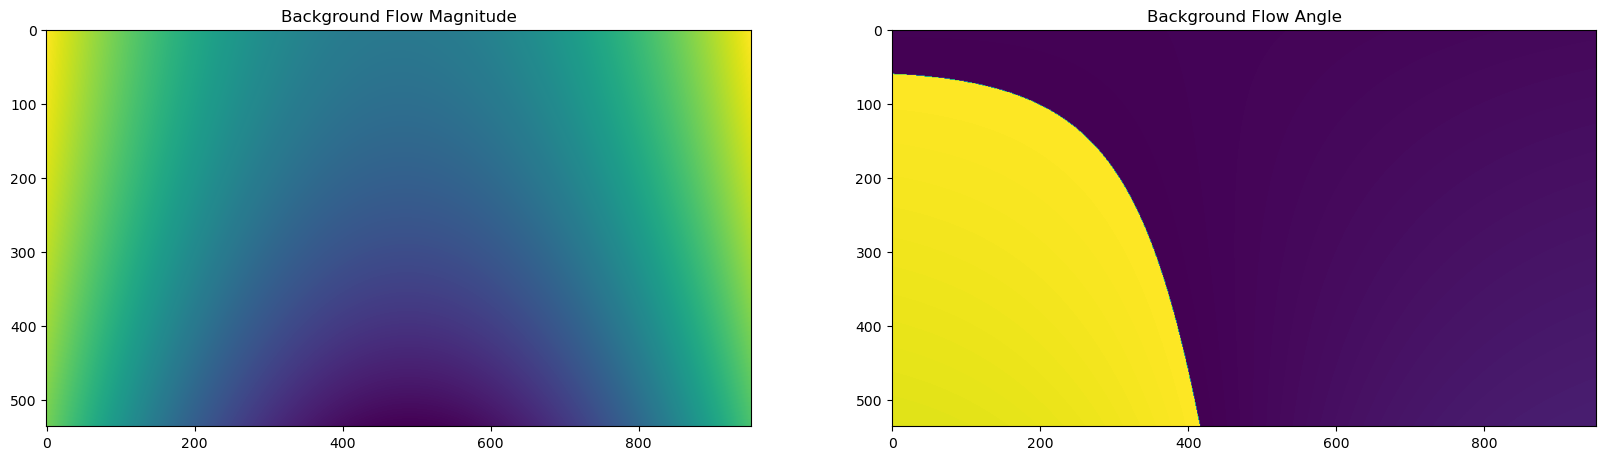

In [186]:
_, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].imshow(mag_b, cmap='viridis')
ax[0].set_title("Background Flow Magnitude")
ax[1].imshow(ang_b, cmap='viridis')
ax[1].set_title("Background Flow Angle");

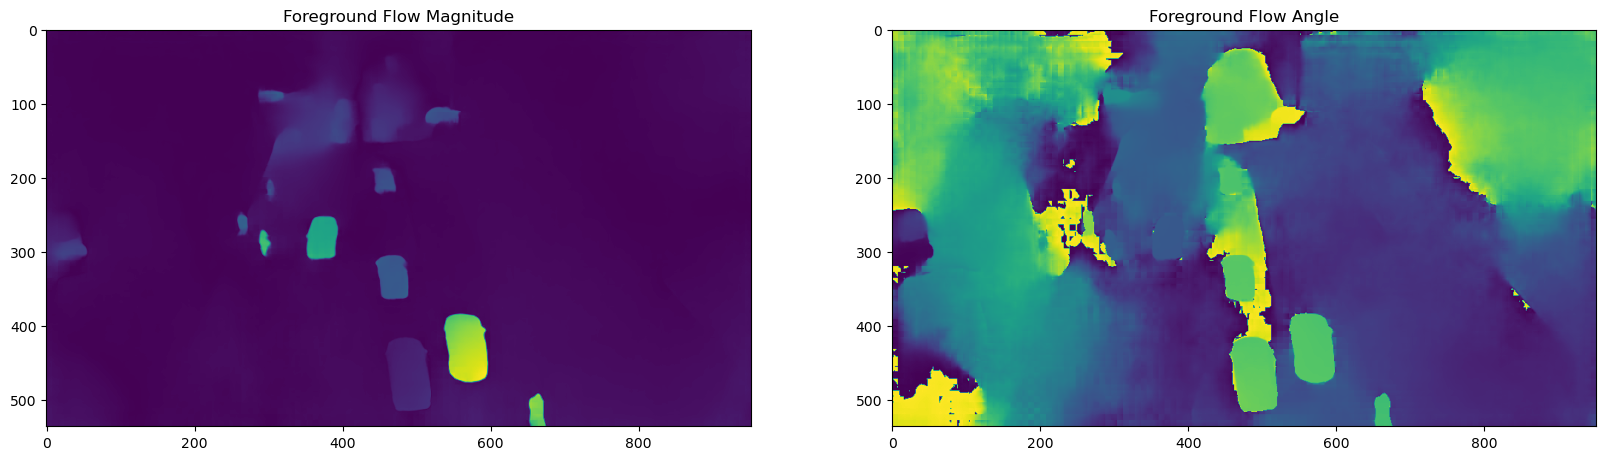

In [187]:
_, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].imshow(mag_f, cmap='viridis')
ax[0].set_title("Foreground Flow Magnitude")
ax[1].imshow(ang_f, cmap='viridis')
ax[1].set_title("Foreground Flow Angle");

### Let's look at all flow estimates

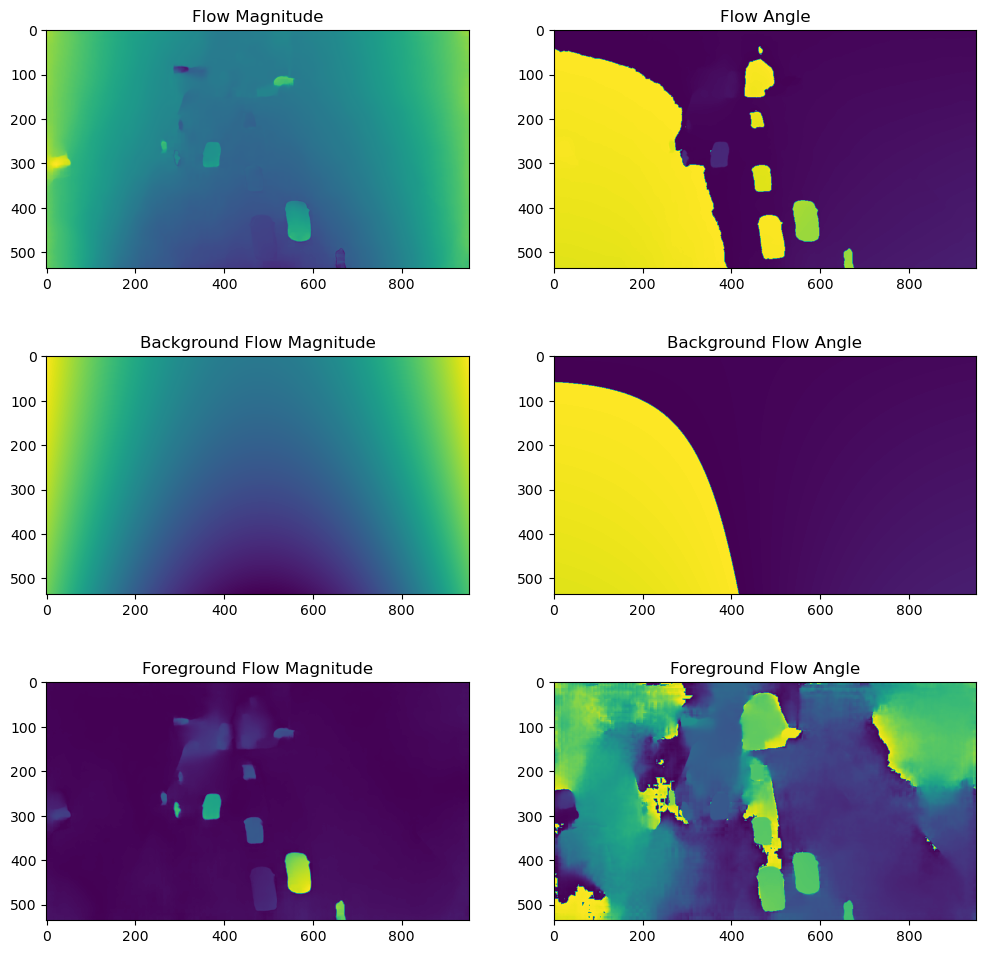

In [188]:
_, ax = plt.subplots(3, 2, figsize=(12, 12))
ax[0, 0].imshow(mag, cmap='viridis')
ax[0, 0].set_title("Flow Magnitude")
ax[0, 1].imshow(ang, cmap='viridis')
ax[0, 1].set_title("Flow Angle");

ax[1, 0].imshow(mag_b, cmap='viridis')
ax[1, 0].set_title("Background Flow Magnitude")
ax[1, 1].imshow(ang_b, cmap='viridis')
ax[1, 1].set_title("Background Flow Angle");

ax[2, 0].imshow(mag_f, cmap='viridis')
ax[2, 0].set_title("Foreground Flow Magnitude")
ax[2, 1].imshow(ang_f, cmap='viridis')
ax[2, 1].set_title("Foreground Flow Angle");

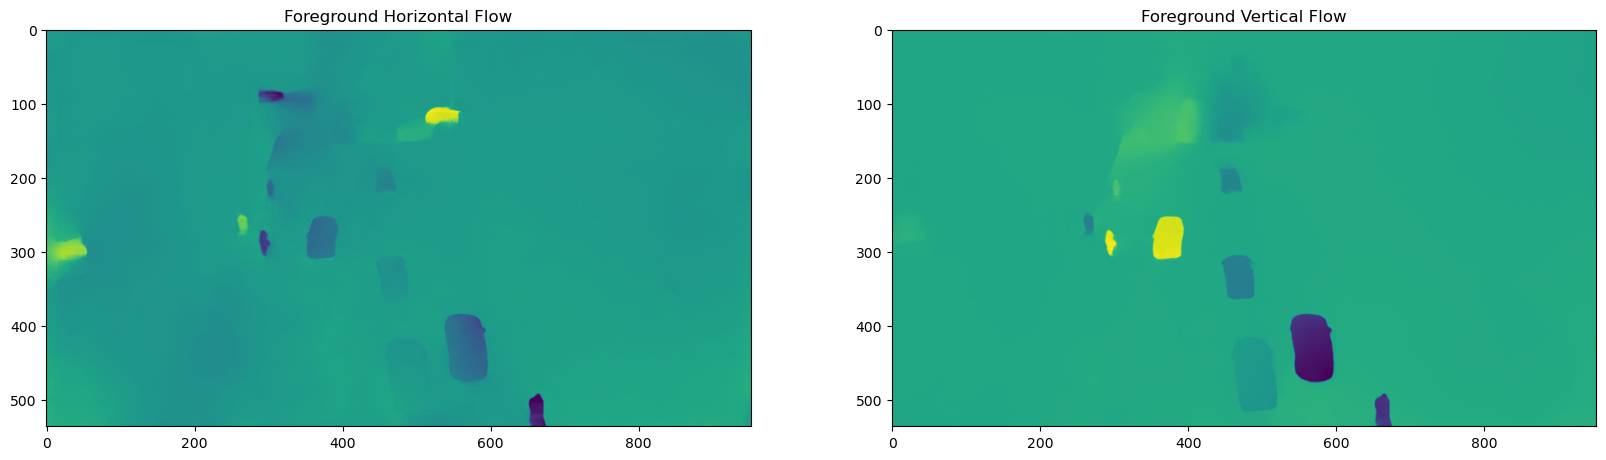

In [189]:
_, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].imshow(foreground_flow[:, :, 0])
ax[0].set_title("Foreground Horizontal Flow")
ax[1].imshow(foreground_flow[:, :, 1])
ax[1].set_title("Foreground Vertical Flow");

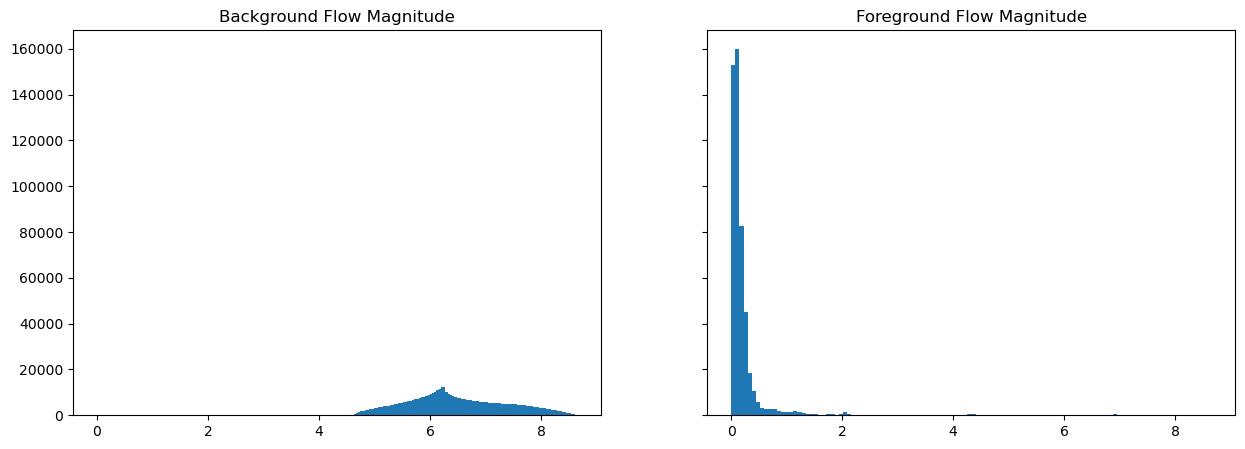

In [190]:
_, ax = plt.subplots(1, 2, figsize=(15, 5), sharex=True, sharey=True)
ax[0].hist(mag_b.flatten(), bins=100);
ax[0].set_title("Background Flow Magnitude")
ax[1].hist(mag_f.flatten(), bins=100);
ax[1].set_title("Foreground Flow Magnitude");

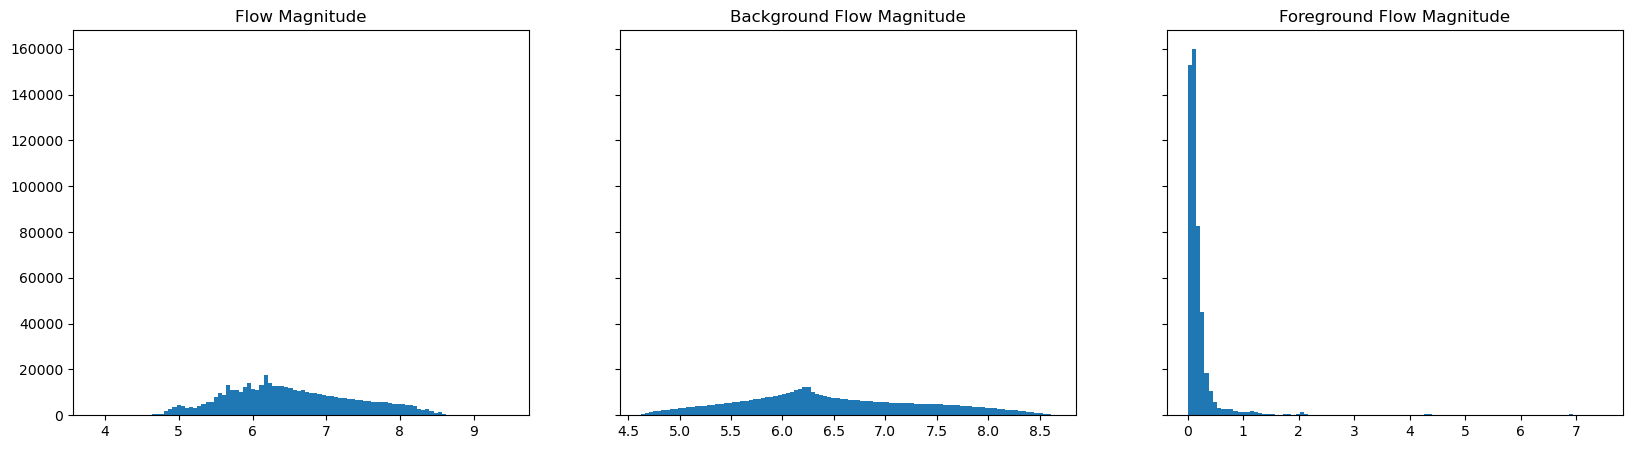

In [191]:
_, ax = plt.subplots(1, 3, figsize=(20, 5), sharey=True)
ax[0].hist(mag.reshape((-1)), bins=100);
ax[0].set_title("Flow Magnitude")
ax[1].hist(mag_b.flatten(), bins=100);
ax[1].set_title("Background Flow Magnitude")
ax[2].hist(mag_f.flatten(), bins=100);
ax[2].set_title("Foreground Flow Magnitude");

## Perform Outlier Detection to get motion mask

In [192]:
c = 0.5 # sensitivty hyperparameter
thresh = mag_f.mean() + c*mag_f.std()

thresh

0.6328889796610543

In [193]:
motion_mask = np.uint8(mag_f > thresh)*255

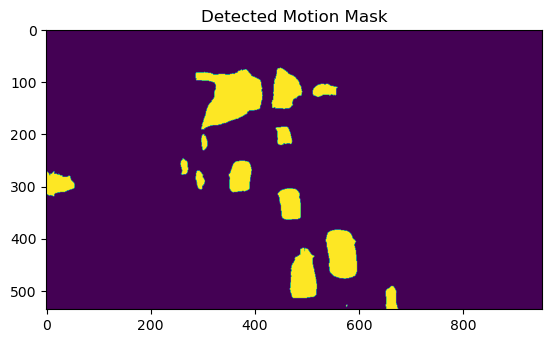

In [194]:
plt.imshow(motion_mask)
plt.title("Detected Motion Mask");

In [115]:
def get_detections(mask, mask_w, mask_h, bbox_thresh=100, edge_thresh=50):
    """
        Obtains Contour detection bboxes on the input mask
        Inputs:
            mask - motion mask
            mask_w - mask width
            mask_h - mask height
            bbox_thresh - Minimum threshold area for declaring a bounding box 
            edge_thresh - min pixel distance to edge for cluster removal
                clusters close to the edge usually correspond to false detections
        Outputs:
            detectons - array of proposed detection bounding boxes and scores 
                        [[x1,y1,x2,y2,s]]
    """
    # remove bad detections
    contours, _ = cv2.findContours(mask, 
                                   cv2.RETR_EXTERNAL, # cv2.RETR_TREE, 
                                   cv2.CHAIN_APPROX_TC89_L1)
    detections = []
    for cnt in contours:
        x,y,w,h = cv2.boundingRect(cnt)
        center = np.array((x + w//2, y + h//2))
        area = w*h
        
        max_bbox_area = mask_w*mask_h/4
        if ((area > bbox_thresh) and (area < max_bbox_area) \
                and np.all((center > edge_thresh)) \
                and np.all(center < np.array([mask_w - edge_thresh, mask_h - edge_thresh]))):
            detections.append([x,y,x+w,y+h, area])

    return np.array(detections)

In [116]:
def detect_motion(frame1, frame2, bbox_thresh=100, edge_thresh=50, ransac_thresh=0.01, ransac_iters=50,  c=0.5, nms_thresh=1e-3):
    """ Detects moving objects from frame 1 to frame 2 using Optical Flow
        Inputs:
            frame1 - previous frame
            frame2 - current frame
            bbox_thresh - Minimum threshold area for declaring a bounding box 
            edge_thresh - min pixel distance to edge for cluster removal
                clusters close to the edge usually correspond to false detections
            ransac_thresh - RANSAC error threshold to consider a point an inlier 
            ransac_iters - Number of RANSAC iteratiions
            c - tunable threshold hyperparamer for outlier detection
                smaller values allow more outliers (and possibly noise) to be detected
            angle_thresh - threshold for angular uniformity of the cluster 
                (Determines if the Std Dev of the Cluster flow angles is too large)
            nms_thresh - IOU threshold for computing Non-Maximal Supression
        Outputs:
            detections - list with bounding box locations of all detections
                bounding boxes are in the form of: (xmin, ymin, xmax, ymax)
        """
    # compute Deep Optical Flow
    flow = inference(model, 
                     frame1, 
                     frame2, 
                     iters=12, 
                     test_mode=False, 
                     device='cuda')[-1].squeeze().cpu().numpy().transpose(1, 2, 0)
    
    ## Use RANSAC to obtain H matrix
    h, w, _ = flow.shape

    # get points P and polynomial expansion X
    P, X = get_px(w, h)

    # get sample index
    index, n_ttl, n_s = get_sampling_index(w, h, s=50, p=0.5)

    # obtain H matrix
    H, _ = cra(flow, P, X, index, n_ttl, n_s, thresh=ransac_thresh, min_inliers=10000, num_iters=ransac_iters)
    # H, _ = cra_fast(flow, P, X, index, n_ttl, n_s, thresh=ransac_thresh, min_inliers=10000, num_iters=ransac_iters)
    
    # use H matrix to get estimated background and foreground
    # print(X.shape, H.shape, P.shape)
    Fb = (X @ H) - P
    background_flow = Fb.reshape(flow.shape)
    
    foreground_flow = flow - background_flow
    mag_f, _ = cv2.cartToPolar(foreground_flow[:, :, 0], foreground_flow[:, :, 1])
    
    # threshold foreground flow to get motion mask
    motion_mask = np.uint8(mag_f > (mag_f.mean() + c*mag_f.std(ddof=1)))*255

    # # (OPTIONAL) clean motion mask
    # kernel = np.ones((3,3))
    # motion_mask = cv2.erode(motion_mask, kernel, iterations=1)
    # motion_mask = cv2.morphologyEx(motion_mask, cv2.MORPH_OPEN, kernel, iterations=1)
    # motion_mask = cv2.morphologyEx(motion_mask, cv2.MORPH_CLOSE, kernel, iterations=1)

    # get initial detections
    detections = get_detections(motion_mask, w, h, bbox_thresh, edge_thresh)

    if len(detections) == 0:
        return []
    
    return detections[:, :4]

    # OPTIONAL perform Non-Max Supression
    # bboxes = detections[:, :4]
    # scores = detections[:, -1]
    # return non_max_suppression(bboxes, scores, nms_thresh)

Test Pipeline

In [195]:
H, W, _ = frame1.shape
H2, W2 = H//2, W//2

resized_1 = cv2.resize(frame1, (W2, H2))
resized_2 = cv2.resize(frame2, (W2, H2))

In [196]:
detections = detect_motion(resized_1, resized_2)
%timeit detections = detect_motion(resized_1, resized_2)

1.03 s ± 40.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [197]:
detections = detect_motion(frame1, frame2, bbox_thresh=10, edge_thresh=15, c=0.5)

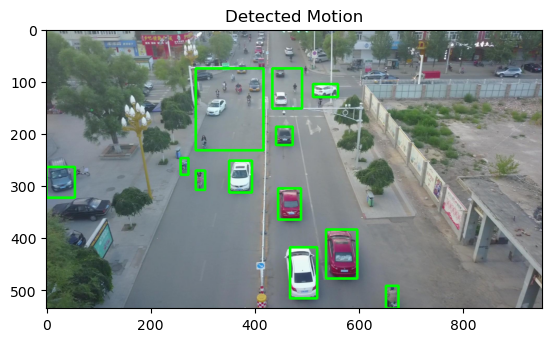

In [198]:
frame1_copy = frame1.copy()

draw_bboxes(frame1_copy, detections)

plt.imshow(frame1_copy)
plt.title("Detected Motion");

### Run on Video Clip

In [83]:
# get previous frame
prev_frame = cv2.imread(image_paths[0])
curr_frame = None

# get smaller frame size
H, W, _ = prev_frame.shape
H2, W2 = H//2, W//2

frames = []
for i in range(1, len(image_paths)):
    curr_frame = cv2.imread(image_paths[i])

    # resize images
    prev_resized = cv2.resize(prev_frame, (W2, H2))
    curr_resized = cv2.resize(curr_frame, (W2, H2))

    # get detections
    detections = detect_motion(prev_resized, 
                               curr_resized,
                               bbox_thresh=25, 
                               edge_thresh=15,
                               ransac_iters=50,
                               ransac_thresh=0.01,
                               c=0.5,
                               nms_thresh=1e-3)

    # print(len(detections))

    # draw detected bounding boxes
    draw_bboxes(prev_resized, detections)

    # save image for GIF
    fig = plt.figure(figsize=(10, 5))
    plt.imshow(prev_resized)
    plt.axis('off')
    fig.savefig(f"temp/frame_{i}.png")
    plt.close();
    
    frames.append(prev_resized)

    # save previous frame for next iteration
    prev_frame = curr_frame.copy()


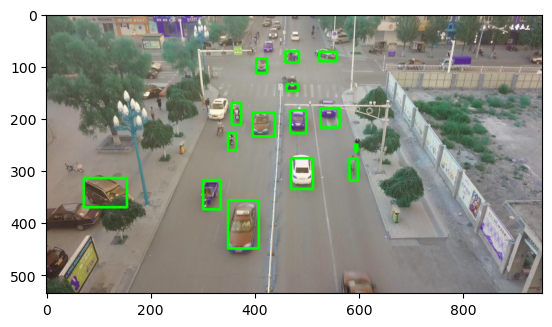

In [55]:
plt.imshow(frames[80]);

#### Make Video

In [56]:
out = cv2.VideoWriter('videos/drone_detection_CRA_360_5.mp4', cv2.VideoWriter_fourcc(*'MP4V'), 15, (W2, H2))

for img in frames:
    out.write(cv2.cvtColor(img, cv2.COLOR_RGB2BGR))

out.release()
del out

#### Make GIF

In [57]:
create_gif_from_images('videos/drone_detection_CRA_360_5.gif', 'temp', '.png', duration=75)

#### Run on more Video Clips!

In [42]:
# fpath = r"C:\Users\itber\Documents\datasets\VisDrone\VisDrone2019-VID-train\sequences\uav0000360_00001_v"
# fpath = r"C:\Users\itber\Documents\datasets\VisDrone\VisDrone2019-VID-train\sequences\uav0000361_02323_v"
fpath = r"C:\Users\itber\Documents\datasets\VisDrone\VisDrone2019-VID-train\sequences\uav0000270_00001_v"
# fpath = r"C:\Users\itber\Documents\datasets\VisDrone\VisDrone2019-VID-train\sequences\uav0000366_00001_v"

image_paths = sorted(glob(f"{fpath}/*.jpg"), key=lambda x:float(re.findall("(\d+)",x)[0]))
len(image_paths)

680

In [43]:
# get previous frame
prev_frame = cv2.imread(image_paths[0])
curr_frame = None

# get smaller frame size
H, W, _ = prev_frame.shape
H2, W2 = H//2, W//2

frames = []
for i in range(1, len(image_paths)):
    curr_frame = cv2.imread(image_paths[i])

    # resize images
    prev_resized = cv2.resize(prev_frame, (W2, H2))
    curr_resized = cv2.resize(curr_frame, (W2, H2))

    # get detections
    detections = detect_motion(prev_resized, 
                               curr_resized,
                               bbox_thresh=25, 
                               edge_thresh=15,
                               ransac_iters=50,
                               ransac_thresh=0.01,
                               c=0.5,
                               nms_thresh=1e-3)

    # draw detected bounding boxes
    draw_bboxes(prev_resized, detections)

    # save image for GIF
    fig = plt.figure(figsize=(10, 5))
    plt.imshow(prev_resized)
    plt.axis('off')
    fig.savefig(f"temp/frame_{i}.png")
    plt.close();
    
    frames.append(prev_resized)

    # save previous frame for next iteration
    prev_frame = curr_frame.copy()


In [44]:
# make video
out = cv2.VideoWriter('videos/drone_detection_CRA_270_5.mp4', cv2.VideoWriter_fourcc(*'MP4V'), 15, (W2, H2))
for img in frames:
    out.write(cv2.cvtColor(img, cv2.COLOR_RGB2BGR))

out.release()
del out

# make GIF
create_gif_from_images('videos/drone_detection_CRA_270_5.gif', 'temp', '.png', duration=75)